In [44]:
# import necessary libraries


import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string

### Data Analysis :

In [45]:
# read dataset

data = pd.read_csv('../../data/train.dat', delimiter='\t')

In [46]:
# add column names

data.columns = ['label','text']

In [47]:
# take a look at dataset

data.head(2)

,label,text
0,5,Renal abscess in children. Three cases of rena...
1,2,Hyperplastic polyps seen at sigmoidoscopy are ...


In [269]:
# get shape of dataset

print("Number of rows in data :",data.shape[0])

Number of rows in data : 14437


In [49]:
# label info from problem statement

label_info = {1:'digestive system diseases',
2:'cardiovascular diseases' ,
3:'neoplasms',
4:'nervous system diseases',
5:'general pathological conditions'}


In [50]:
# get condition column using label info

data['conditions'] = data.label.apply(lambda x:label_info[x])

In [51]:
# look of dataset

data.head(2)

,label,text,conditions
0,5,Renal abscess in children. Three cases of rena...,general pathological conditions
1,2,Hyperplastic polyps seen at sigmoidoscopy are ...,cardiovascular diseases


In [52]:
# get valuecounts for conditions

data.conditions.value_counts()

general pathological conditions    4805
digestive system diseases          3163
nervous system diseases            3050
neoplasms                          1925
cardiovascular diseases            1494
Name: conditions, dtype: int64

In [261]:
# create encoding dictionary for class label

id_label = {i:j for i,j in enumerate(data.conditions.unique())}
labei_id = {j:i for i,j in enumerate(data.conditions.unique())}

In [98]:
# label id dictionary

labei_id

{'general pathological conditions': 0,
 'cardiovascular diseases': 1,
 'nervous system diseases': 2,
 'digestive system diseases': 3,
 'neoplasms': 4}

In [53]:
# create function to plot categories

def plot_count(feature,data_frame):

    # plot countplot of body_type and add count on each bar
    plt.figure(figsize=(8,8))
    sns.countplot(y=feature,data=data_frame)
    plt.title(f'Count of categories in {feature}')
    for p in plt.gca().patches:
        plt.gca().annotate('{:.0f}'.format(p.get_width()), (p.get_width(), p.get_y()+p.get_height()/2.), ha='center', va='center', xytext=(10, 0), textcoords='offset points')
    plt.show()

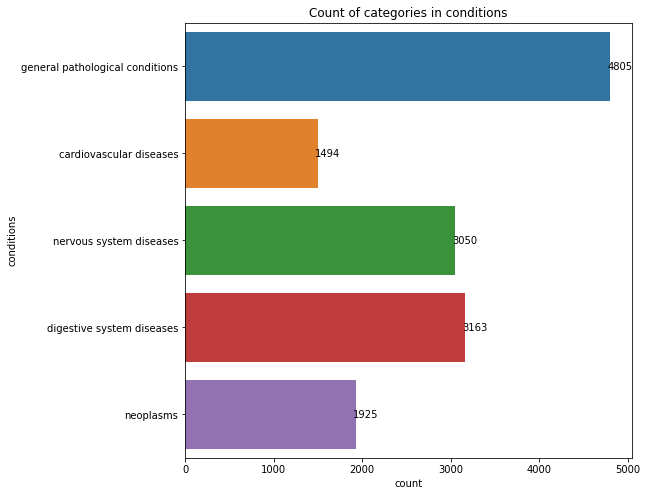

In [54]:
# plot countplot for conditions

plot_count('conditions',data)

In [55]:
# analysis of maximum lenghth of text

data['len_words'] = data['text'].astype(str).apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='len_words', ylabel='Count'>

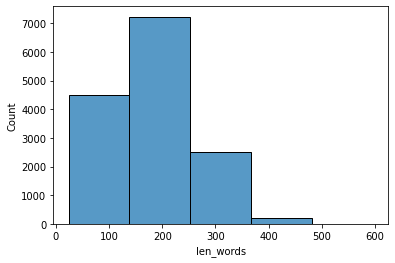

In [56]:
# plot len of text
sns.histplot(data['len_words'], bins=5)

In [57]:
# find the percentile value of len of text

# english
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(data['len_words'], i)))

10 Quantile is 79.0
20 Quantile is 108.0
30 Quantile is 136.0
40 Quantile is 157.0
50 Quantile is 176.0
60 Quantile is 198.0
70 Quantile is 221.0
80 Quantile is 249.0
90 Quantile is 275.0
100 Quantile is 596.0


In [58]:
# find the percentile value of len of text
# english
for i in np.arange(0.9,1.01,0.01):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(data['len_words'], i)))

90 Quantile is 275.0
91 Quantile is 278.0
92 Quantile is 282.0
93 Quantile is 287.0
94 Quantile is 294.0
95 Quantile is 302.0
96 Quantile is 315.0
97 Quantile is 330.0
98 Quantile is 351.28000000000065
99 Quantile is 383.0
100 Quantile is 596.0


In [59]:
# create a function for basic pre-processing

# stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
#             "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
#             'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
#             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
#             'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
#             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
#             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
#             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
#             'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
#             'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
#             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
#             've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
#             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
#             "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
#             'won', "won't", 'wouldn', "wouldn't"])

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\d", " ", text)
    text = re.sub(r"<.*?>+", "", text)
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://S+|www.\.\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r'xx', '', text)
    text = decontracted(text)
    words = text.split()
#     words = [word for word in words if not word in stopwords]
#     words = [re.sub(r"(.)\1{1,}", r"\1\1", word) for word in words]
    words = [word.strip() for word in words if len(word.strip()) > 1]
    text = " ".join(words)
    return text

In [60]:
# check on one text

txt = "marketed a preapproval program on creditkarma to refinance a car at a lower rate, it said i could get preapproved with no affect on my credit, company i was sent to is XXXX didnt like the offers on XX/XX/XXXX so didnt move forward and today XX/XX/XXXX XXXX checked my credit and summitted it to XXXX XXXX XXXX Inquired on XX/XX/XXXX On record until XX/XX/XXXX XXXX XXXX XXXXXXXX XXXX Inquired on XX/XX/XXXX On record until XX/XX/XXXX XXXX XXXX XXXX  Inquired on XX/XX/XXXX On record until XX/XX/XXXX i reached out and was told i gave explict consent and "

preprocess_text(txt)

'marketed preapproval program on creditkarma to refinance car at lower rate it said could get preapproved with no affect on my credit company was sent to is didnt like the offers on so didnt move forward and today checked my credit and summitted it to inquired on on record until inquired on on record until inquired on on record until reached out and was told gave explict consent and'

In [61]:
# apply pre-processing on complaint columns

data["text"] = data["text"].apply(preprocess_text)

In [120]:
data.text.values[2]

'subclavian artery to innominate vein fistula after insertion of hemodialysis catheter insertion of hemodialysis catheters for temporary use is now preferentially performed by percutaneous infraclavicular subclavian vein catheterization this method involves passage of stiff dilator and peelaway sheath over guide wire and is usually carried out without fluoroscopy for the most part this has proved to be valuable and safe approach however small incidence of major complications occurs which needs to be emphasized sixteen cases of arteriovenous fistulas between the subclavian artery or its branches and the subclavian vein have been reported so far in the literature to date only one case of subclavian artery to innominate vein fistula has been reported we report the second case with this complication and suggest possible preventive measures'

In [121]:
data.conditions.values[2]

'general pathological conditions'

In [62]:
# data.to_csv('train_data.csv')

### LSTM:

In [20]:
#import necessary liabraries

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [21]:
# create x and y columns

X = data['text']
y = data['conditions']

In [22]:
# Split into training and temporary set (temp_set)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y,random_state=42)

In [23]:
# Tokenization on data

token_eng = Tokenizer()
token_eng.fit_on_texts(X_train.astype(str))

In [24]:
# vocab size for given dataset

vocab_size=len(token_eng.word_index.keys())
print('Vocab size of text data',vocab_size)


Vocab size of text data 40189


In [25]:
# convert text to numbers

max_len = 350

# text to sequence

X_train = token_eng.texts_to_sequences(X_train.astype(str))
X_test = token_eng.texts_to_sequences(X_test.astype(str))

In [26]:
# pad sequence to max length

x_train_seq = pad_sequences(X_train, maxlen=max_len, padding='post', dtype='int32')
x_test_seq = pad_sequences(X_test, maxlen=max_len, padding='post', dtype='int32')

In [27]:
# get shape of tokenize data

x_train_seq.shape

(11549, 350)

In [28]:
# use one hot encoding since our target is categorical

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

#### LSTM Model Architecture:

In [30]:
# create a model architecture

total_vocabulary = vocab_size + 1

model = Sequential()

embedding_size = 128
model.add(Embedding(total_vocabulary, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

In [31]:
# compile model and get model summary

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary() # check the shape

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         5144320   
                                                                 
 lstm (LSTM)                 (None, None, 25)          15400     
                                                                 
 global_max_pooling1d (Globa  (None, 25)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 50)                1300      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

# Step 3: Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [33]:
# fit model defining epoch and batch size

history = model.fit(x_train_seq, y_train, epochs=30, batch_size=32,validation_data=(x_test_seq, y_test), callbacks=[early_stopping])

Epoch 1/30
361/361 [==============================] - 59s 156ms/step - loss: 1.3691 - accuracy: 0.4312 - val_loss: 1.1040 - val_accuracy: 0.5561
Epoch 2/30
361/361 [==============================] - 55s 153ms/step - loss: 1.0767 - accuracy: 0.5757 - val_loss: 1.0611 - val_accuracy: 0.5651
Epoch 3/30
361/361 [==============================] - 55s 153ms/step - loss: 0.9206 - accuracy: 0.6362 - val_loss: 1.0546 - val_accuracy: 0.5471
Epoch 4/30
361/361 [==============================] - 54s 150ms/step - loss: 0.8038 - accuracy: 0.6856 - val_loss: 1.1472 - val_accuracy: 0.5377
Epoch 5/30
361/361 [==============================] - 55s 153ms/step - loss: 0.7051 - accuracy: 0.7222 - val_loss: 1.1780 - val_accuracy: 0.5353
Epoch 6/30
361/361 [==============================] - 58s 160ms/step - loss: 0.6447 - accuracy: 0.7415 - val_loss: 1.3844 - val_accuracy: 0.5132
Epoch 7/30
361/361 [==============================] - 58s 161ms/step - loss: 0.5960 - accuracy: 0.7582 - val_loss: 1.3492 - val_ac

In [37]:
# save modelin model folder

model.save('../../model/lstm_model.h5')

### Inference on new query point

In [262]:
def get_prediction(test_data):
    pre_text = preprocess_text(test_data)
    token_text = token_eng.texts_to_sequences([pre_text])
    pad_text = pad_sequences(token_text, maxlen=350, padding='post', dtype='int32')
    predictions = model.predict(pad_text.reshape(1,-1))
#     print(predictions)
    # Example post-processing for a classification task
    predicted_labels = np.argmax(predictions, axis=1)
#     print(predicted_labels)
    return id_label[predicted_labels[0]]

In [266]:
# get model predictions 
num = 3
query = data.text.values[num]
pred = get_prediction(query)
print(pred)
print("*"*100)

print("Ground truth is :",data.conditions.values[num])

1/1 [==============================] - 0s 39ms/step
nervous system diseases
****************************************************************************************************
Ground truth is : nervous system diseases
